### This notebook contains a detailed walkthrough for training a semantic segmentation model on Mitochondria dataset using 2D UNet architecture. 

###### Reference: The code for 2D UNet was developed using the architecture from the paper '<i><u>U-Net: Convolutional Networks for Biomedical Image Segmentation</u></i>' (https://arxiv.org/abs/1505.04597). Some references were taken from Abhishek Thakur's video on implementing 2D UNet from scratch.

### Load libraries

In [1]:
import numpy as np
from skimage import io

from sklearn.model_selection import train_test_split
from patchify import patchify


import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from unet import UNet
import glob
from matplotlib import pyplot as plt


#### Clear GPU memory

In [2]:
torch.cuda.empty_cache() 

#### Load 2D slices of images and masks generated from ImageJ Software

In [3]:
training_images_paths = glob.glob('./training_images/*.tif')

In [4]:
training_masks_paths = glob.glob('./training_masks/*.tif')

#### We define a class called 'Patch' that takes the image and corresponding masks as the input. The images and masks are in the 'tif' format but major formats are also supported. We also create a method 'generate_patches' that generates patches of size 256x256 from each image using the patchify library.

In [5]:
class Patch:
    def __init__(self, image_paths, masks_paths):
        self.images  = image_paths
        self.masks = masks_paths
        
    def generate_patches(self):
        all_image_patches= []
        all_mask_patches = []
        
        for img_path, mask_path in zip(self.images, self.masks):
            img = io.imread(img_path)
            mask = io.imread(mask_path)
            
            image_patch = patchify(img, (256,256), step=256)
            mask_patch = patchify(mask, (256,256), step=256)
            
            image_patch = image_patch.reshape(-1,1, 256, 256)
            mask_patch = mask_patch.reshape(-1, 256, 256)
            
            all_image_patches.append(image_patch) 
            all_mask_patches.append(mask_patch)
        
        image_patches = np.concatenate(all_image_patches)
        mask_patches = np.concatenate(all_mask_patches)

        
        return image_patches, mask_patches

In [6]:
patcher = Patch(training_images_paths, training_masks_paths)
image_patches, mask_patches = patcher.generate_patches()

#### Next, we create a PyTorch Dataset and DataLoader class.

In [10]:
class MitochondriaDataset(Dataset):
    def __init__(self, images, masks):
        
        self.images  = images
        self.masks = masks
        

        
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self,idx):
        
        mask = np.where(self.masks[idx]== 255, 1, 0) #Convert image mask into a binary mask
        
        #normalize the image
        image = (self.images[idx]  - self.images[idx].mean())/self.images[idx].std()
        
        image = image.astype('float32')
        mask = mask.astype('float32')
        
        image = torch.from_numpy(image)
        mask  = torch.from_numpy(mask)
        mask = mask.type(torch.LongTensor)#### Next, we create a PyTorch Dataset and DataLoader class.
        
        return image, mask
        

#### To evaluate the perfomance of our model, we would split these voxels into training and validation sets. We have kept 80% of the dataset for training and remaining 20% for validation set.

In [11]:
patches_train, patches_val, masks_train, masks_val = train_test_split(image_patches,mask_patches, test_size=.2)


In [12]:
train_ds = MitochondriaDataset(patches_train, masks_train)
val_ds = MitochondriaDataset(patches_val, masks_val)

#### Wrap the dataset object around the PyTorch dataloader. 

In [13]:
train_dl = DataLoader(train_ds,batch_size=2, shuffle=True)
val_dl = DataLoader(val_ds,batch_size=2, shuffle=False)

#### It is highly advisable to use GPU otherwise training would be really slow.

In [15]:
device = torch.device("cuda:2" if torch.cuda.is_available()  else "cpu")


#### The images have unequal distribution of pixels belonging to mitochondria class(1) or not (0) i.e. the dataset poses a class imbalance problem. To solve this, we have assigned lower weights to the majority class and higher weights to the minority class. Later on, we would pass these weights into our loss function.

In [17]:
def compute_class_weights(labels):
    
    class_weights = []
    
    labels = np.where(labels == 255, 1, 0)
    n_classes = list(np.unique(labels))
    n_samples = labels.size
    
    for i in range(len(n_classes)):
        class_weights.append(n_samples/((len(n_classes))*np.sum(labels==i)))
        
    return class_weights

#### Reference: Code to compute class weights was referred from https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [18]:
class_weights = compute_class_weights(mask_patches)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
class_weights

tensor([0.5298, 8.8804], device='cuda:2')

#### Next, we define number of classes and learning rate. We also intialize the 2D UNet model, Adam optimizer and loss fucntion along with computed class weights.

In [19]:
n_classes = 2
learning_rate = 1e-4


model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


#### We define a function 'run_one_epoch' that iterates over the dataloader, computes cross entropy weighted loss, backpropogates the weight (only if dataloader is a training set, indicated by boolean flag) and finally computes the dice coefficient score.

#### Reference: The code for computing the dice coefficient was referred from open-sourced github repo under free license.

In [20]:
def run_one_epoch(dataloader, model, optimizer, train_flag=True):
    dice = []
    losses = []
    
    if train_flag:
        model.train()
    else:
        model.eval()
        
        
    for x,y in train_dl:
        x=x.to(device)
        y=y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        if train_flag:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
        
        smooth = 1.
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.max(y_pred,1)[1]
        
        iflat = y_pred.contiguous().reshape(-1)
        tflat = y.contiguous().reshape(-1)
        intersection = (iflat * tflat).sum()
        
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        
        dice.append(((2. * intersection + smooth) / (A_sum + B_sum + smooth)).item())
        
        
    return np.mean(losses), np.mean(dice)
        

#### Now that we have everything in place, let's  train the model for 10 epochs initially only and see how the loss function behaves. We would also save the loss values and dice coefficients at the end of every epoch.

In [21]:
train_losses = []
val_losses = []
train_dice = []
val_dice = []
for i in range(10):
    train_loss, train_dice_coeff = run_one_epoch(train_dl, model, optimizer)
    val_loss, val_dice_coeff = run_one_epoch(val_dl, model, optimizer, False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    train_dice.append(train_dice_coeff)
    val_dice.append(val_dice_coeff)
    print("train loss %.2f valid loss %.2f train_dice_coeff %.2f val_dice_coeff %.2f" %(train_loss, val_loss,train_dice_coeff, val_dice_coeff))

train loss 0.18 valid loss 0.07 train_dice_coeff 0.60 val_dice_coeff 0.76
train loss 0.08 valid loss 0.06 train_dice_coeff 0.72 val_dice_coeff 0.71
train loss 0.05 valid loss 0.03 train_dice_coeff 0.79 val_dice_coeff 0.83
train loss 0.04 valid loss 0.05 train_dice_coeff 0.80 val_dice_coeff 0.72
train loss 0.04 valid loss 0.03 train_dice_coeff 0.81 val_dice_coeff 0.87
train loss 0.03 valid loss 0.03 train_dice_coeff 0.84 val_dice_coeff 0.86
train loss 0.03 valid loss 0.02 train_dice_coeff 0.85 val_dice_coeff 0.86
train loss 0.04 valid loss 0.03 train_dice_coeff 0.83 val_dice_coeff 0.85
train loss 0.03 valid loss 0.05 train_dice_coeff 0.85 val_dice_coeff 0.74
train loss 0.03 valid loss 0.02 train_dice_coeff 0.85 val_dice_coeff 0.87


#### We achieved dice coefficient score of 0.87 on the validation set after training the model for just 10 epochs.

In [25]:
for i in range(10):
    train_loss, train_dice_coeff = run_one_epoch(train_dl, model, optimizer)
    val_loss, val_dice_coeff = run_one_epoch(val_dl, model, optimizer, False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    train_dice.append(train_dice_coeff)
    val_dice.append(val_dice_coeff)
    print("train loss %.2f valid loss %.2f train_dice_coeff %.2f val_dice_coeff %.2f" %(train_loss, val_loss,train_dice_coeff, val_dice_coeff))

train loss 0.02 valid loss 0.02 train_dice_coeff 0.87 val_dice_coeff 0.88
train loss 0.02 valid loss 0.02 train_dice_coeff 0.87 val_dice_coeff 0.87
train loss 0.02 valid loss 0.02 train_dice_coeff 0.88 val_dice_coeff 0.91
train loss 0.02 valid loss 0.02 train_dice_coeff 0.88 val_dice_coeff 0.86
train loss 0.03 valid loss 0.02 train_dice_coeff 0.86 val_dice_coeff 0.90
train loss 0.02 valid loss 0.02 train_dice_coeff 0.88 val_dice_coeff 0.87
train loss 0.03 valid loss 0.02 train_dice_coeff 0.86 val_dice_coeff 0.91
train loss 0.02 valid loss 0.02 train_dice_coeff 0.89 val_dice_coeff 0.91
train loss 0.02 valid loss 0.03 train_dice_coeff 0.89 val_dice_coeff 0.84
train loss 0.02 valid loss 0.02 train_dice_coeff 0.88 val_dice_coeff 0.88


#### Let's plot training and validation loss vs number of epochs to inspect the training behaviour.

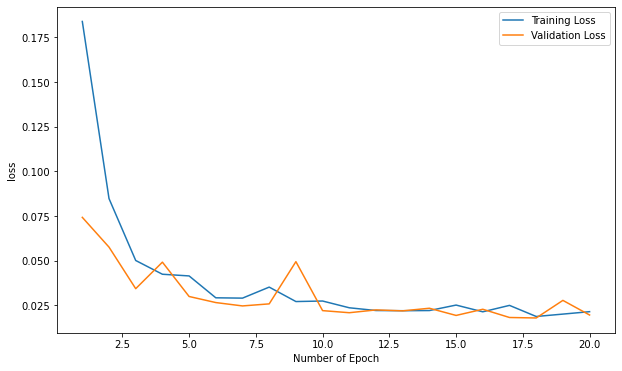

In [27]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(range(1,21),train_losses,label = "Training Loss")
ax.plot(range(1,21), val_losses,label = "Validation Loss")
ax.set_xlabel('Number of Epoch') 
ax.set_ylabel('loss')    
plt.legend()   
plt.show()    

#### Plot Training and Validation Dice Coefficient score vs Number of Epochs.

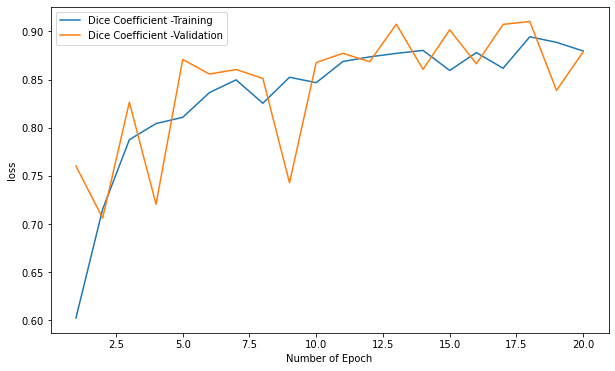

In [28]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(range(1,21),train_dice,label = "Dice Coefficient -Training")
ax.plot(range(1,21), val_dice,label = "Dice Coefficient -Validation")
ax.set_xlabel('Number of Epoch') 
ax.set_ylabel('loss')    
plt.legend()   
plt.show()    

#### Save the model

In [29]:
torch.save(model.state_dict(), './model_2DUnet.pth')